In [4]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from hmpai.training import split_participants, split_participants_custom
from hmpai.pytorch.training import train_and_test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, load_model
from hmpai.pytorch.generators import MultiXArrayProbaDataset
from hmpai.data import SAT_CLASSES_ACCURACY
from hmpai.pytorch.normalization import *
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
from hmpai.behaviour.sat2 import SAT2_SPLITS
from hmpai.visualization import predict_with_auc, set_seaborn_style, plot_peak_timing
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from pymer4.models import Lmer
DATA_PATH = Path(os.getenv("DATA_PATH"))

labels_t1 = ["negative", "t1_1", "t1_2", "t1_3"]
labels_t2 = ["negative", "t2_1", "t2_2", "t2_3"]
labels_cmb = ["negative", "t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"]
set_global_seed(42)

data_paths = [DATA_PATH / "prp/stage_data_250hz_t2.nc"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def plot_pred_peak_timing(peaks):
    set_seaborn_style()
    # Melt the dataframe to long format for easier plotting with seaborn
    melted_df = peaks.melt(id_vars="condition", var_name="Operation", value_name="Time")
    melted_df["Time"] = (melted_df["Time"] / 250)  # Convert to seconds

    # Create the boxplots
    plt.figure(figsize=(6, 3))
    sns.violinplot(data=melted_df, x="Operation", y="Time", hue="condition")
    plt.xlabel("Operation")
    plt.ylabel("Absolute timing (seconds)")
    plt.ylim(0, 1.0)
    plt.legend(title="Condition")
    plt.tight_layout()
    plt.show()

def plot_pred_peak_timing_since_previous(peaks):
    set_seaborn_style()
    # Melt the dataframe to long format for easier plotting with seaborn
    peaks = peaks.copy()
    for i in range(len(peaks.columns) - 1, 1, -1):
        peaks.iloc[:, i] = peaks.iloc[:, i] - peaks.iloc[:, i - 1]
    mean_df = peaks.groupby("condition").mean().reset_index()
    mean_df.iloc[:,1:] = mean_df.iloc[:,1:] / 250
    print(mean_df)
    melted_df = peaks.melt(id_vars="condition", var_name="Operation", value_name="Time")
    melted_df["Time"] = (melted_df["Time"] / 250)  # Convert to seconds
    # Create the boxplots
    plt.figure(figsize=(6, 3))
    sns.violinplot(data=melted_df, x="Operation", y="Time", hue="condition")
    plt.xlabel("Operation")
    plt.ylabel("Time since last event (seconds)")
    # plt.ylim(0, 1.0)
    plt.legend(title="Condition")
    plt.tight_layout()
    plt.show()

def plot_pred_vs_true_peak_timing(labels, ax_long, ax_short, path: Path, cue_var="condition", sample=True, val_participants=None):
    df = pd.read_csv(path)
    set_seaborn_style()
    for i_label, label in enumerate(labels):
        if label == "negative":
            continue
        df[f"{label}_pred"] /= df["rt_samples"]
        df[f"{label}_true"] /= df["rt_samples"]

        scatter_subset = df[df[cue_var] == 'long']
        if val_participants is not None:
            scatter_subset = scatter_subset[scatter_subset["participant"].isin(val_participants)]
        elif sample:
            scatter_subset = scatter_subset.sample(n=len(scatter_subset[scatter_subset["participant"].isin(val_participants)]))

        sns.scatterplot(
            scatter_subset,
            x=f"{label}_pred",
            y=f"{label}_true",
            alpha=0.1,
            ax=ax_long,
            color=sns.color_palette()[i_label - 1],
            linewidth=0,
        )
        scatter_subset = df[df[cue_var] == 'short']

        if labels[1].startswith("t2_"):
            sns.kdeplot(
                scatter_subset[f"{label}_pred"],
                ax=ax_short,
                fill=True,
                color=sns.color_palette()[i_label - 1],
            )
        else:
            if sample:
                scatter_subset = scatter_subset.sample(frac=0.1)
            sns.scatterplot(
                scatter_subset,
                x=f"{label}_pred",
                y=f"{label}_true",
                alpha=0.1,
                ax=ax_short,
                color=sns.color_palette()[i_label - 1],
                linewidth=0,
        )

def plot_peak_topos(path: Path, labels, positions, conditions, cue_var="condition", val_participants=None):
    df = pd.read_csv(path)
    set_seaborn_style()
    fig, axs = plt.subplots(2, len(labels) - 1, figsize=(6, 4))
    for i_cond, condition in enumerate(conditions):
        cur_df = df[df[cue_var] == condition]
        # In long condition, only show peaks for val participants
        if condition == 'long' and val_participants is not None:
            cur_df = cur_df[cur_df["participant"].isin(val_participants)]
        axs[i_cond, 0].set_ylabel(condition)
        for i, label in enumerate(labels):
            if label == "negative":
                continue
            # Get the peak values for the current label
            # Convert list value to numpy array
            peak_values = cur_df[f"{label}_peak_values"].apply(eval)
            peak_values = np.array([np.array(x) for x in peak_values]).mean(axis=0)[:64]
            mne.viz.plot_topomap(peak_values, positions, axes=axs[i_cond, i - 1], show=False, cmap='Spectral_r')
            if i_cond == 0:
                axs[i_cond, i - 1].set_title(label)
    fig.supylabel("Condition")
    fig.suptitle("Operation")
    fig.tight_layout()
    return fig

def plot_diff_topos_within_task(path: Path, label, positions, conditions, cue_var="condition"):
    df = pd.read_csv(path)
    set_seaborn_style()
    fig, axs = plt.subplots(3, 1, figsize=(6, 4))
    peak_values_coll = []
    for i_cond, condition in enumerate(conditions):
        cur_df = df[df[cue_var] == condition]
        axs[i_cond].set_ylabel(condition)
        peak_values = cur_df[f"{label}_peak_values"].apply(eval)
        peak_values = np.array([np.array(x) for x in peak_values]).mean(axis=0)[:64]
        peak_values_coll.append(peak_values)
        mne.viz.plot_topomap(peak_values, positions, axes=axs[i_cond], show=False, cmap='Spectral_r', vlim=(-2, 2))
    # Calculate the difference between the two conditions
    diff = peak_values_coll[0] - peak_values_coll[1]
    mne.viz.plot_topomap(diff, positions, axes=axs[2], show=False, cmap='Spectral_r', vlim=(-2, 2))
    axs[2].set_ylabel("diff")
    fig.tight_layout()
    return fig

### Analysis combined

In [ ]:
set_global_seed(42)

data_paths = [DATA_PATH / "prp/stage_data_250hz_t2.nc"]
# 80/20 train/val (no test)
splits = split_participants_custom(data_paths, 0.15)
# info_path = DATA_PATH / "sat2/preprocessed_500hz/preprocessed_S1_raw.fif"
info_path = DATA_PATH / "prp/epoched/VP1-t1-epo.fif"

epoch = mne.read_epochs(info_path)
epoch.set_montage("biosemi64")
positions = epoch.info

Reading /workspace/data_local/prp/epoched/VP1-t1-epo.fif ...
    Found the data of interest:
        t =    -250.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
834 matching events found
No baseline correction applied
0 projection items activated


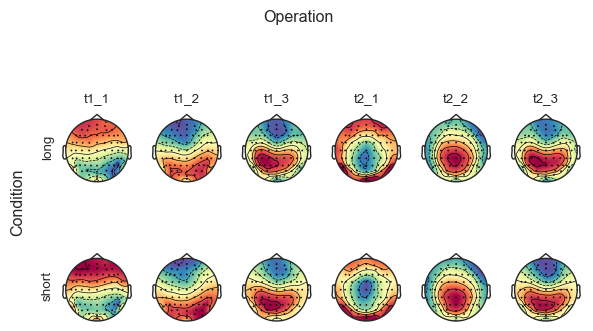

In [ ]:
fig = plot_peak_topos(Path("files/cmb_peaks.csv"), labels_cmb, positions, conditions=['long', 'short'], cue_var="condition", val_participants=splits[1])
fig.show()

### Analysis task 1

In [3]:
set_global_seed(42)

data_paths = [DATA_PATH / "prp/stage_data_250hz_t2.nc"]
# 80/20 train/val (no test)
splits = split_participants_custom(data_paths, 0.15)
# info_path = DATA_PATH / "sat2/preprocessed_500hz/preprocessed_S1_raw.fif"
info_path = DATA_PATH / "prp/epoched/VP1-t1-epo.fif"

epoch = mne.read_epochs(info_path)
epoch.set_montage("biosemi64")
positions = epoch.info

Reading /workspace/data_local/prp/epoched/VP1-t1-epo.fif ...
    Found the data of interest:
        t =    -250.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
834 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
fig = plot_peak_topos(Path("files/t1_peaks.csv"), labels_t1, positions, conditions=['long', 'short'], cue_var="condition", val_participants=splits[1])
fig.show()

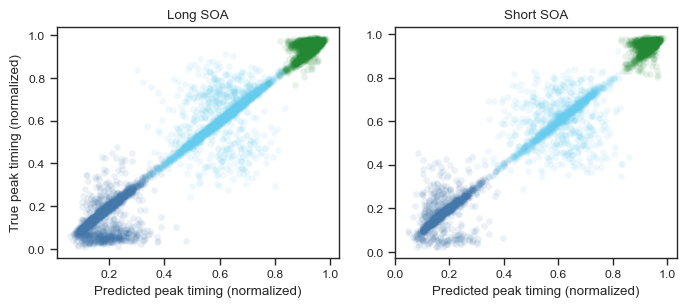

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
set_seaborn_style()
plot_pred_vs_true_peak_timing(labels_t1, axs[0], axs[1], path=Path("files/t1_peaks.csv"), sample=True, val_participants=splits[1])
axs[0].set_ylabel("True peak timing (normalized)")
axs[0].set_xlabel("Predicted peak timing (normalized)")
axs[1].set_ylabel("")
axs[1].set_xlabel("Predicted peak timing (normalized)")
axs[0].set_title("Long SOA")
axs[1].set_title("Short SOA")
fig.show()

### Analysis Task 2

In [ ]:
# info_path = DATA_PATH / "sat2/preprocessed_500hz/preprocessed_S1_raw.fif"
info_path = DATA_PATH / "prp/epoched/VP1-t2-epo.fif"

epoch = mne.read_epochs(info_path)
epoch.set_montage("biosemi64")
positions = epoch.info

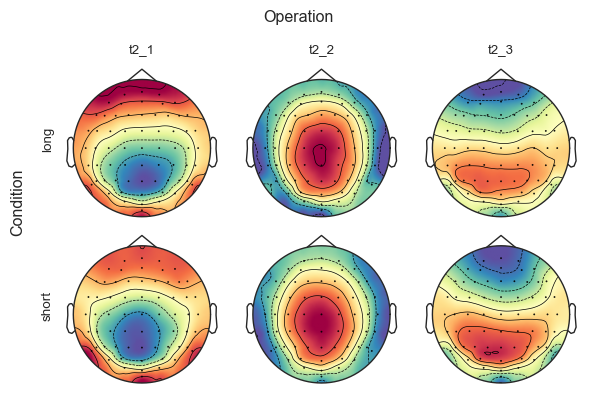

In [31]:
fig = plot_peak_topos(Path("files/t2_peaks.csv"), labels_t2, positions, conditions=['long', 'short'], cue_var="condition", val_participants=splits[1])
fig.show()

In [ ]:
# select columns including 'condition', 'pred', or 'true'
t2_df = pd.read_csv(Path("files/t2_peaks.csv"))
t2_df = t2_df.loc[:, t2_df.columns.str.contains('condition|pred')]
mean_df = t2_df.groupby("condition").mean().reset_index()
mean_df[["t2_1_pred", "t2_2_pred", "t2_3_pred"]] = mean_df[["t2_1_pred", "t2_2_pred", "t2_3_pred"]] / 250
mean_df
# At how many seconds is the peak generally seen?

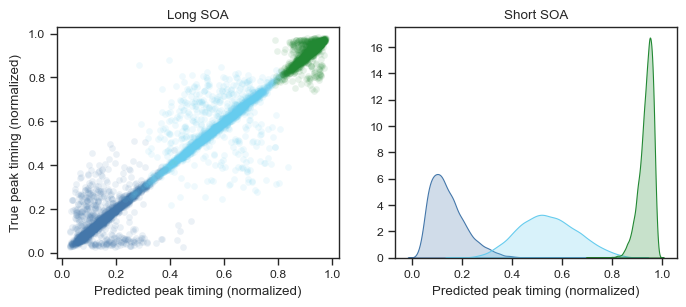

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
set_seaborn_style()
plot_pred_vs_true_peak_timing(labels_t2, axs[0], axs[1], path=Path("files/t2_peaks.csv"), sample=False, val_participants=splits[1])
axs[0].set_ylabel("True peak timing (normalized)")
axs[0].set_xlabel("Predicted peak timing (normalized)")
axs[1].set_ylabel("")
axs[1].set_xlabel("Predicted peak timing (normalized)")
axs[0].set_title("Long SOA")
axs[1].set_title("Short SOA")
fig.show()

In [ ]:
plot_pred_peak_timing(t2_df)

In [ ]:
plot_pred_peak_timing_since_previous(t2_df)

In [ ]:
import scipy.stats as stats

def calc_stats(df, operation="t2_3"):
    # Subset and convert to seconds
    df_long = df[df["condition"] == "long"][operation].to_numpy()
    df_short = df[df["condition"] == "short"][operation].to_numpy()

    stat, p = stats.mannwhitneyu(df_long, df_short)
    print(f'Operation: {operation}, U-statistic: {stat}, p-value: {p}')
    
for operation in t2_df.keys()[1:]:
    calc_stats(t2_df, operation=operation)
for operation in t1_df.keys()[1:]:
    calc_stats(t1_df, operation=operation)

### Analysis combined

In [3]:
# info_path = DATA_PATH / "sat2/preprocessed_500hz/preprocessed_S1_raw.fif"
info_path = DATA_PATH / "prp/epoched/VP1-t1-epo.fif"

epoch = mne.read_epochs(info_path)
epoch.set_montage("biosemi64")
positions = epoch.info
labels_cmb = labels_t1 + labels_t2[1:]

Reading /workspace/data_local/prp/epoched/VP1-t1-epo.fif ...
    Found the data of interest:
        t =    -250.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
844 matching events found
No baseline correction applied
0 projection items activated


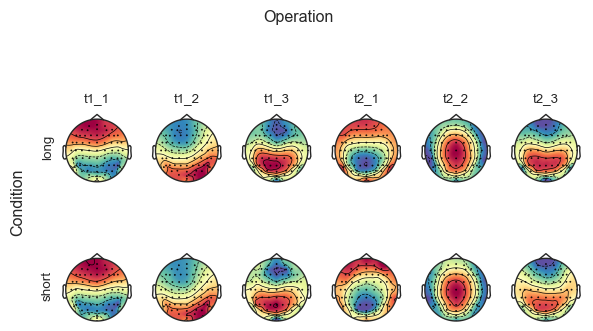

In [4]:
fig = plot_peak_topos(Path("files/cmb_peaks.csv"), labels_cmb, positions, conditions=['long', 'short'], cue_var="condition")
fig.show()

In [ ]:
fig = plot_diff_topos_within_task(Path("files/cmb_peaks.csv"), "t1_3", positions, conditions=['long', 'short'], cue_var="condition")
fig.show()

In [ ]:
# select columns including 'condition', 'pred', or 'true'
t1_df = pd.read_csv(Path("files/cmb_peaks.csv"))
t1_df = t1_df.loc[:, t1_df.columns.str.contains('condition|pred')]
mean_df = t1_df.groupby("condition").mean().reset_index()
mean_df[["t1_1_pred", "t1_2_pred", "t1_3_pred", "t2_1_pred", "t2_2_pred", "t2_3_pred"]] = mean_df[["t1_1_pred", "t1_2_pred", "t1_3_pred", "t2_1_pred", "t2_2_pred", "t2_3_pred"]] / 250
mean_df
# At how many seconds is the peak generally seen?

In [ ]:
plot_pred_peak_timing(t1_df)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
set_seaborn_style()
plot_pred_vs_true_peak_timing(labels_cmb, axs[0], axs[1], path=Path("files/cmb_peaks.csv"), sample=True)
axs[0].set_ylabel("True peak timing (normalized)")
axs[0].set_xlabel("Predicted peak timing (normalized)")
axs[1].set_ylabel("")
axs[1].set_xlabel("Predicted peak timing (normalized)")
axs[0].set_title("Long SOA")
axs[1].set_title("Short SOA")
fig.show()